## wgMLST for mbovis

* http://www3.ridom.de/seqsphere/cgmlst/
* https://www.cgmlst.org/ncs/schema/741110/
* https://jcm.asm.org/content/52/7/2479
* https://www.biorxiv.org/content/10.1101/172858v1.full
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3980634/

## steps

* get MLST gene list
* assembly
* annotate
* assign allele numbers?

In [29]:
import sys,os,shutil,subprocess
import glob
import random
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)
import pylab as plt
import seaborn as sns
from Bio import SeqIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from io import StringIO
import pathogenie as pg
import snipgenie
import toytree, toyplot

In [2]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
vcf_file='/storage/btbgenie/wicklow_results/filtered.vcf.gz'

In [3]:
def get_samples_vcf(vcf_file):
    cmd = 'bcftools query -l %s' %vcf_file
    tmp = subprocess.check_output(cmd, shell=True)
    return tmp.decode().split('\n')
    
samplenames = get_samples_vcf(vcf_file)

In [4]:
path = '/storage/btbgenie/mbovis_ireland/Wicklow/'
files = glob.glob(os.path.join(path,'**', '*.fastq.gz'),recursive=True)
samp = snipgenie.get_samples(files,sep='_')
pairs = pd.pivot_table(samp,index=['sample'],columns=['pair'],values='filename',aggfunc='first').reset_index()
print (pairs[:2])

pair    sample                                                                                             1  \
0         1034                  /storage/btbgenie/mbovis_ireland/Wicklow/dog/1034_S91_L001-4_R2_001.fastq.gz   
1     13-11594  /storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_15-03-19/13-11594_S85_L001-4_R1_001.fastq.gz   

pair                                                                                             2  
0                     /storage/btbgenie/mbovis_ireland/Wicklow/dog/1034_S91_L001-4_R1_001.fastq.gz  
1     /storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_15-03-19/13-11594_S85_L001-4_R2_001.fastq.gz  


## create reference proteins for MLST

In [6]:
def make_reference_proteins():
    prots = pg.tools.genbank_to_dataframe('Mbovis-AF212297.2.gb',cds=True)
    prots = prots.fillna('')
    prots = prots.dropna(subset=['locus_tag'])
    ref_proteins = 'Mbovis_AF212297_proteins.fa'
    #get prokka type header for using in annotation
    prots['header'] = prots.apply(lambda x: '~~~'.join([x.locus_tag,x.gene,x['product'],'none']),1)
    pg.tools.dataframe_to_fasta(prots,idkey='header',outfile=ref_proteins)
    print (len(prots))
    return prots

prots=make_reference_proteins()

3994


In [5]:
def get_nucleotide_sequences(gb_file,out_file,idkey='locus_tag'):
    """protein nucleotide seqs from genbank"""
    
    recs = SeqIO.to_dict(SeqIO.parse(gb_file,'genbank'))
    chroms = list(recs.keys())
    result = []
    for chrom in chroms[:10]:       
        rec = recs[chrom]        
        for f in rec.features[1:]:
            q=f.qualifiers
            if f.type != 'CDS':
                continue
            seq = rec.seq[f.location.start:f.location.end]
            try:         
                new = SeqRecord(seq,id=q[idkey][0])
                result.append(new)
            except:
                #print (q)
                pass
    SeqIO.write(result,out_file,format='fasta')
    return result

res=get_nucleotide_sequences('Mbovis-AF212297.2.gb','Mbovis_AF212297_nuc.fa')

## assembly

In [ ]:
def spades(file1, file2, path, outfile=None, threads=4):
    """Run spades"""
    
    cmd = 'spades -t %s --pe1-1 %s --pe1-2 %s --careful -o %s' %(threads,file1,file2,path)    
    if not os.path.exists(path): 
        print (cmd)
        subprocess.check_output(cmd, shell=True)
    if outfile != None:
        shutil.copy(os.path.join(path,'scaffolds.fasta'),outfile)
    return outfile

assembly_path = '/storage/btbgenie/assembly/'

for i,r in pairs[5:10].iterrows():    
    name=r['sample']
    print (name)
    out = os.path.join(assembly_path,name+'.fa')
    print (out)
    spades(r[1], r[2], os.path.join(assembly_path,name), outfile=out, threads=12)

## get consensus sequence from alignment instead of assembly

In [7]:
def get_consensus(vcf_file, sample, out_file='consensus.fa'):
    """Get consensus sequence from vcf"""
      
    cmd='bcftools index -f %s' %vcf_file
    subprocess.check_output(cmd, shell=True)   
    cmd='cat {r} | bcftools consensus -s {s} {v} > {o}'.format(r=snipgenie.app.mbovis_genome,v=vcf_file,s=sample,o=out_file)
    #print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

get_consensus(vcf_file, '1034','consensus.fa')


## annotate


In [ ]:
seqfile='/storage/btbgenie/assembly/1034.fa'
#seqfile='consensus.fa'
featdf,recs = pg.run_annotation(seqfile,
                                threads=10, kingdom='bacteria', trusted=ref_proteins)
outfile='/storage/btbgenie/annotation_assembly/1034.fa'

#write out nucl sequences
SeqIO.write(recs,'temp.gb','genbank')
res = get_nucleotide_sequences('temp.gb',outfile,idkey='protein_id')

In [853]:
rec=res[3]
print (rec.id)
rec.seq.translate()

Mb3672c


Seq('MPQGTVKWFNAEKGFGFIAPEDGSADVFVHYTEIQGTGFRTLEENQKVEFEIGH...SL*')

# initialise MLST table from reference genome

## filter only Mb proteins in scheme

In [27]:
mlst=pd.read_csv('mlst_scheme.csv')
mlst=mlst[mlst['Ridom Usage']=='MLST+']
targets=list(mlst.Target)

In [28]:
mbmap=pd.read_csv('final_mbovis_mapping.csv')
mbmap = mbmap[mbmap.Rv_tag.isin(targets)]
mb_tags = list(mbmap.Mb_tag)
prots = prots[prots.locus_tag.isin(mb_tags)]
nucseqs = pg.tools.fasta_to_dataframe('Mbovis_AF212297_nuc.fa')
nucseqs = nucseqs[nucseqs.name.isin(mb_tags)]

In [29]:
cols = ['name','allele','sequence']
ref = nucseqs.copy()
ref['allele'] = 1
ref=ref.rename(columns={'translation':'sequence'})
ref[cols].to_csv('mlst_db.csv.gz',index=False,compression='gzip')
print (len(ref))

3184


In [13]:
fastafile='/storage/btbgenie/annotation_assembly/1034.fa'
df = pg.tools.fasta_to_dataframe(fastafile)
df[df.name=='Mb0014c']

,name,sequence,description,type
3240,Mb0014c,CTACTGGCCGAACCTCAGCGTGATGATGCCGTCCCGGTTGACGCCGGTCCCCGCCGGCGGGTTTTGATAGACGACCCGGTTGTGTTGGGAGCCACCGGCGTCGACGTCGGCCCCTTTGTCGAGCATCCCGGTCCAGCCCAGCGCGC...,Mb0014c <unknown description>,CDS


In [8]:
def find_alleles(fastafile):
    """Find allele by simple matches to the reference table of known sequences.
    Returns:
        dataframe with allele number for each gene
        dataframe with new alleles to add to db
    """
    
    db = pd.read_csv('mlst_db.csv.gz')
    names = db.name.unique()
    df = pg.tools.fasta_to_dataframe(fastafile).reset_index()
    #print (df.iloc[0])
    result=[]
    new=[]
    for name in names:
        #print (name)
        s = db[db.name==name]
        gene = df[df.name==name]
        #print (gene)
        if len(gene)==0:
            #print (name)
            #missing gene in target
            result.append((name,0))
            continue
        target = gene.iloc[0].sequence
        found = s[s.sequence==target]        
        #print (target,found)
        if len(found)>0:
            found = found.iloc[0]
            result.append((name,found.allele))
        else:
            #assign new allele            
            newallele = s.allele.max()+1
            result.append((name,newallele))
            new.append([name,newallele,target])
    prof = pd.DataFrame(result,columns=['name','allele'])
    prof['allele'] = prof.allele.astype(int)
    #new additions
    new = pd.DataFrame(new,columns=['name','allele','sequence'])
    return prof, new
    
def update_mlst_db(new):
    """Update the database of MLST profiles"""
    
    db = pd.read_csv('mlst_db.csv.gz')
    db = pd.concat([db,new])
    db.to_csv('mlst_db.csv.gz', index=False, compression='gzip')
    print ('added %s new alleles' %len(new))
    return

fastafile='26-Mbovis.fa'
#prof,new = find_alleles(fastafile)
#update_mlst_db(new)
#print (prof[:100])

In [25]:
def type_sample(fastafile, outfile, threads=4, overwrite=False):
    """Type a single sample using wgMLST.
    Args:
        fastafile: fasta file to type from assembly or other
        
        path: output folder for annotations
    Returns:
        dataframe of MLST profile
    """
    
    ref_proteins = 'Mbovis_AF212297_proteins.fa'
    if overwrite == True or not os.path.exists(outfile):
        #annotate
        featdf,recs = pg.run_annotation(fastafile, threads=threads,
                                        kingdom='bacteria', trusted=ref_proteins)
        #get nucl sequences from annotation    
        SeqIO.write(recs,'temp.gb','genbank')
        get_nucleotide_sequences('temp.gb',outfile,idkey='protein_id')
    
    #find alleles
    res,new = find_alleles(outfile)
    #print (res)
    #update db
    update_mlst_db(new)
    return res

get_consensus(vcf_file, '26-MBovis')
fastafile = 'consensus.fa'
res = type_sample(fastafile, '26-Mbovis.fa', threads=10)

added 0 new alleles


In [10]:
def get_profile_string(df):
    return ''.join(df.allele.astype(str))

## profiles from assembly - not needed?

In [ ]:
profs = {}
omit=['182-MBovis','19-4281','19-2438']
samples=glob.glob(os.path.join(assembly_path,'*.fa'))
pdf=pd.DataFrame()
for s in samples:
    print (s)
    sample = os.path.splitext(os.path.basename(s))[0]    
    if sample in omit:
        continue
    profile = type_sample(s, '/storage/btbgenie/annotation_assembly/%s.fa' %sample, threads=12)
    pdf[sample] = profile['allele']
    profs[sample] = get_profile_string(profile)

## profiles from consensus seqs

In [11]:
def run_samples(vcf_file, outdir, omit=[], **kwargs):
    """Run samples in a vcf file.
    Args:
        vcf_file: multi sample variant file from previous calling
        outdir: folder for writing intermediate files
    Returns:
        dict of mst profiles
    """

    profs = {}
    samplenames = get_samples_vcf(vcf_file)
    print (samplenames)
    for s in samplenames[:15]:
        print (s)
        if s in omit or s =='':
            continue
        get_consensus(vcf_file, s)
        outfile = os.path.join(outdir, '%s.fa' %s)
        profile = type_sample('consensus.fa', outfile, **kwargs)
        profs[s] = list(profile.allele)
    return profs

## find distances between mlst profiles

In [12]:
def diff_profiles(s1, s2):    
    return sum(1 for a, b in zip(s1, s2) if a != b)

In [13]:
def dist_matrix(profiles):
    """Distance matrix of a set of profiles"""
    
    dist=[]
    for s in profiles:
        x=profiles[s]
        row=[]
        for s in profiles:
            d = diff_profiles(x,profiles[s])
            row.append(d)
        dist.append(row)
    D = pd.DataFrame(dist,columns=profiles.keys(),index=profiles.keys())
    return D

In [14]:
def tree_from_distmatrix(D, treefile):
    
    from skbio import DistanceMatrix
    from skbio.tree import nj
    ids = list(D.index)
    dm = DistanceMatrix(D.values, ids)
    tree = nj(dm)
    #print(tree.ascii_art())
    tree.write(treefile, 'newick')
    return tree

In [ ]:
import random
test = {'A':'1112233','B':'1112213','C':'2111213','D':'2111232','E':'212211','F':'2111222'}

d = dist_matrix(test)
tree_from_distmatrix(d)
tre = toytree.tree(treefile)
canvas,t,r=tre.draw(layout='r',scalebar=True,width=500)
sns.clustermap(d,figsize=(5,5))

## test on wicklow samples

In [ ]:
omit=['182-MBovis','19-4281','19-2438']
profs = run_samples(vcf_file, '/storage/btbgenie/annotation_consensus', threads=12, omit=omit)
for i in profs:
    print (i,len(profs[i]))

In [57]:
D = dist_matrix(profs)
D.to_csv('dist_mlst.csv',index=False)
#sns.clustermap(D,xticklabels=True,yticklabels=True,figsize=(6,6))
treefile='temp.newick'
tree_from_distmatrix(D, treefile)
tre = toytree.tree(treefile)
tre=tre.root('43-MBovis')
canvas,t,r=tre.draw(layout='r',scalebar=True,height=400,width=500)
import toyplot.png
#toyplot.png.render(canvas, "mlst-tree.png")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t76a87b1d39c6487899583756d17cca82"> 42-MBovis 59-MBovis 37-MBovis 38-MBovis 23-MBovis 25-MBovis 39-MBovis 49-MBovis 1034 50-MBovis 36-MBovis 24-MBovis 29-MBovis 43-MBovis 0 8 16 24 31

In [58]:
tre2 = toytree.tree('/storage/btbgenie/wicklow_results/tree.newick')
drop = list(set(tre2.get_tip_labels()) - set(tre.get_tip_labels()))
tre2=tre2.drop_tips(drop)
tre2=tre2.root('43-MBovis')
canvas,t,r=tre2.draw(layout='r',scalebar=True,height=400,width=500)
#toyplot.png.render(canvas, "snp-tree.png")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta80dac38d5244d8b9fb1d41ae0c73b62"> 49-MBovis 39-MBovis 23-MBovis 25-MBovis 38-MBovis 42-MBovis 59-MBovis 37-MBovis 36-MBovis 50-MBovis 24-MBovis 29-MBovis 1034 43-MBovis 0 9 19 28 37

# sensitivity analysis - SNPs vs MLST

## phastsim

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7987011/

In [80]:
refseq = SeqIO.read('Mbovis_AF212297.fa','fasta')
scale = (1/len(refseq))*3
#scale=8e-6
cmd = 'phastSim --outpath simulation_output/ --seed 1 --createFasta' \
         ' --createPhylip --treeFile sim.newick' \
         ' --scale {s} --invariable .1 --alpha 1.0 --omegaAlpha 1.0' \
         ' --reference Mbovis_AF212297.fa'.format(s=scale)
cmd

'phastSim --outpath simulation_output/ --seed 1 --createFasta --createPhylip --treeFile sim.newick --scale 6.896703927259084e-07 --invariable .1 --alpha 1.0 --omegaAlpha 1.0 --reference Mbovis_AF212297.fa'

In [102]:
simrecs = list(SeqIO.parse('sim_seqs3.fa','fasta'))
diff_profiles(simrecs[2].seq,simrecs[4].seq)

3

## make fastqs from sequences

In [17]:
def make_fastq(ref, outfile, cmp=100):
    
    f1 = '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/17-MBovis_S21_L001-4_R1_001.fastq.gz'
    f2 = '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/17-MBovis_S21_L001-4_R2_001.fastq.gz'
    cmd = 'java -jar /local/ArtificialFastqGenerator/ArtificialFastqGenerator.jar -O {o}'\
          ' -R {r} -S ">temp" -RL 150 -CMP {cmp} -CSD 0.2 -SE true'.format(r=ref, o=outfile,cmp=cmp,f1=f1,f2=f2) #-URQS true -F1 {f1} -F2 {f2}
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

In [103]:
def generate_fastqs(infile, outpath):
    
    from joblib import Parallel, delayed
    import multiprocessing, time
    num_cores = 4
    
    simrecs = list(SeqIO.parse(infile,'fasta'))
    def my_func(rec):
        from tempfile import mkstemp
        x,tmp = mkstemp()
        SeqIO.write(SeqRecord(rec.seq,id='temp'), tmp, 'fasta')
        out = os.path.join(outpath,rec.id)
        make_fastq(tmp, out)

    st = time.time()
    Parallel(n_jobs=num_cores)(delayed(my_func)(i) for i in simrecs)
    print (time.time()-st)
    cmd = 'pigz %s/*.fastq' %outpath
    subprocess.check_output(cmd, shell=True)
    
generate_fastqs('sim_seqs3.fa', 'sim_fastq3')
#generate_fastqs('sim_seqs1.fa', 'sim_fastq1')

554.2817695140839


## run snipgenie on simulated fastqs

In [ ]:
import snipgenie
args = {'threads':10, 'outdir': 'sim_results3', 'labelsep':'_',
        'input':['sim_fastq3'],# 'overwrite':True,
         'species':'Mbovis-AF212297',        
         'custom_filters': True,       
         'buildtree':True}
W = snipgenie.app.WorkFlow(**args)
st = W.setup()
W.run()

In [162]:
tresnps = toytree.tree('sim_results3/tree.newick')
tresnps=tresnps.root('7')
tresnps=tresnps.drop_tips('ref')
canvas,t,r=tresnps.draw(layout='r',scalebar=True,height=400,width=500,tip_labels_style={"font-size":"19px"})
sd=snpdist = pd.read_csv('sim_results3/snpdist.csv',index_col=0).iloc[1:,1:]
canvas.text(300, 20, "SNP", style={"font-size":"32px"});
import toyplot.png
#toyplot.png.render(canvas, "snp_tree_sim.png")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t7798fba6282643af9cecc8d81390260f"> 1 9 3 8 4 5 2 6 7 0 7 13 20 26 SNP method ~20 SNPs

In [ ]:
tresboot = toytree.mtree('sim_results3/RAxML_bootstrap.variants')
canvas,t,r=tresboot.draw(layout='r', nrows=2, ncols=5,height=400,width=700)

## mlst on simulated fastqs

In [ ]:
sim_vcf = 'sim_results3/filtered.vcf.gz'
simprofs = run_samples(sim_vcf, 'sim_mlst3', threads=12)

In [148]:
D = dist_matrix(simprofs)
D.to_csv('dist_mlst.csv')
treefile='mlst3.newick'
tree_from_distmatrix(D, treefile)
tremlst = toytree.tree(treefile)
tremlst=tremlst.root('7')
canvas,t,r=tremlst.draw(layout='r',scalebar=True,height=400,width=500,tip_labels_style={"font-size":"19px"})
canvas.text(300, 20, "wgMLST", style={"font-size":"32px"});
#toyplot.png.render(canvas, "wgmlst_tree_sim.png")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td0a1a1d4196447ad9390038956e2b263"> 3 8 1 5 9 4 6 2 7 0 2 4 6 8 wgMLST

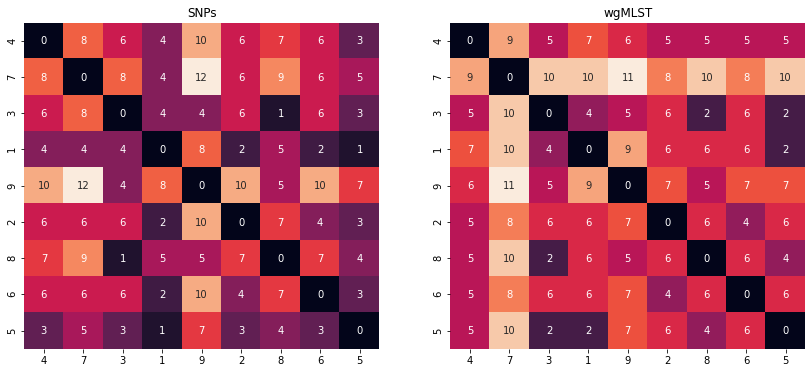

In [158]:
fig,ax=plt.subplots(1,2,figsize=(14,6))
sns.heatmap(sd,annot=True,cbar=False,ax=ax[0])
sns.heatmap(D,annot=True,cbar=False,ax=ax[1])
ax[0].set_title('SNPs')
ax[1].set_title('wgMLST')
plt.savefig('sim_dist_heatmaps.png')

In [136]:
import dendropy
from dendropy.calculate import treecompare
tns = dendropy.TaxonNamespace()
reftree = dendropy.Tree.get(path='sim.newick', schema='newick',taxon_namespace=tns)
tree1 = dendropy.Tree.get(path='mlst3.newick', schema='newick',taxon_namespace=tns)
tree2 = dendropy.Tree.get(path='sim_results1/RAxML_bestTree.variants', schema='newick',taxon_namespace=tns)


In [138]:
print(treecompare.euclidean_distance(reftree, tree1))
print(treecompare.euclidean_distance(reftree, tree2))

4.898976053175999
5.389472890360061
